In [1]:
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import torch

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Config
batch_size = 100
n_iters = 5000
num_epochs = None


In [4]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [5]:
num_epochs = int(n_iters / (len(train_dataset) / batch_size))

In [6]:
samples = iter(train_dataloader)
samples._next_data()[0].shape

torch.Size([100, 1, 28, 28])

In [7]:
class FullyConnectedAutoEncode(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FullyConnectedAutoEncode, self).__init__()
        # Encoder: Affine Function
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Decoder: Affine Function
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # Encoder: affine function
        out = self.fc1(x)
        # Encoder: non-linear function
        out = F.leaky_relu(out)

        # Decoder: affine function
        out = self.fc2(out)
        # Decoder: non-linear function
        out = torch.sigmoid(out)

        return out

    
    
input_dim = 28*28
hidden_dim = int(input_dim * 1.5)
output_dim = input_dim
learning_rate = 1e-3

model = FullyConnectedAutoEncode(input_dim, hidden_dim, output_dim).to(device=device)
criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
idx = 0
# Dropout for creating noisy images
# by dropping out pixel with a 50% probability
dropout = nn.Dropout(0.5)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        images = images.reshape(-1, 28*28)
        noisy_image = dropout(torch.ones(images.shape)) * images
        noisy_image = noisy_image.to(device)
        images = images.to(device)

        optim.zero_grad()

        output = model(noisy_image)

        loss = criterion(images, output)

        loss.backward()

        optim.step()

        idx += 1

        if idx % 500 == 0:
            with torch.no_grad():
                total_test_samples = 0
                total_test_loss = 0
                for images_, labels_ in test_dataloader:
                    
                    # Noisy images
                    images_ = images_
                    noisy_image = dropout(torch.ones(images_.shape)) * images_
                    images_ = images_.to(device)
                    noisy_image = noisy_image.to(device)
                    
                    # Forward pass only to get logits/output
                    outputs = model(noisy_image.view(-1, 28*28))

                    # Test loss
                    test_loss = criterion(outputs, images_.view(-1, 28*28))

                    # Total number of labels
                    total_test_samples += labels.size(0)

                    # Total test loss
                    total_test_loss += test_loss

                mean_test_loss = total_test_loss / total_test_samples

                # Print Loss
                print(f'Iteration: {idx}. Average Test Loss: {mean_test_loss.item()}.')

Iteration: 500. Average Test Loss: 0.00016279000556096435.
Iteration: 1000. Average Test Loss: 0.00014316865417640656.
Iteration: 1500. Average Test Loss: 0.0001375880092382431.
Iteration: 2000. Average Test Loss: 0.00012435053940862417.
Iteration: 2500. Average Test Loss: 0.00012100208550691605.
Iteration: 3000. Average Test Loss: 0.00011781906505348161.
Iteration: 3500. Average Test Loss: 0.00011563726729946211.
Iteration: 4000. Average Test Loss: 0.00011399706272641197.
Iteration: 4500. Average Test Loss: 0.00011298555182293057.


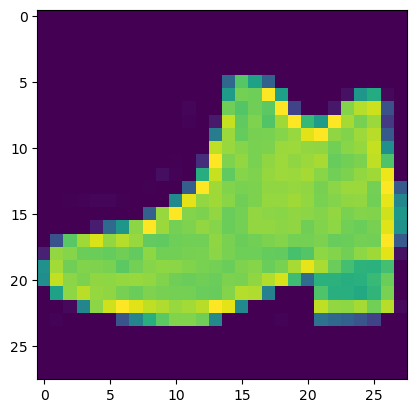

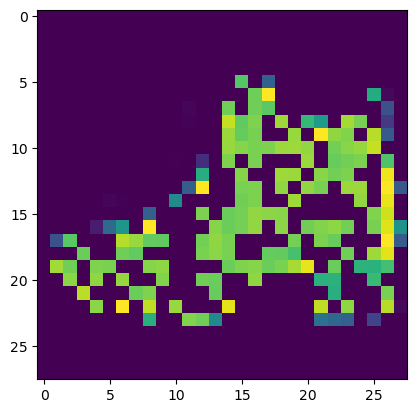

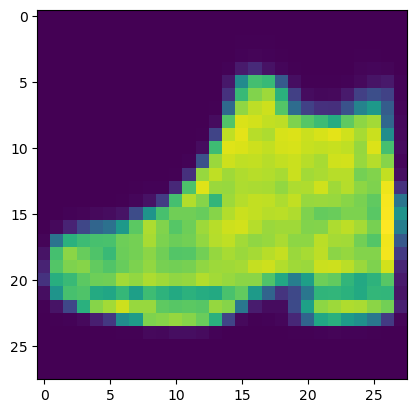

In [27]:
import matplotlib.pyplot as plt
sample_number = 15
img = train_dataset[sample_number][0]
noisy_image = dropout(torch.ones(img.shape)) * img
with torch.no_grad():
    predicted = model(noisy_image.view(-1, 28*28).to(device))
plt.imshow(img.reshape(28, 28))
plt.show()
plt.imshow(noisy_image.reshape(28, 28))
plt.show()
plt.imshow(predicted.to('cpu').reshape(28, 28))
plt.show()